In [45]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

import yaml
import os
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

In [98]:
tasks = ['hospital_mortality', 'LOS_7', 'icu_admission', 'readmission_30']
metrics = ['auc', 'auprc', 'ace_abs_logistic_log']
model_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models'
results_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/results'
figure_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/notebooks/figures'


titles = {'hospital_mortality':'In-hospital Mortality', 'LOS_7':'Length of Stay > 7 days', 'icu_admission':'Admission to ICU', 'readmission_30':'Readmission after 30 days'}

In [112]:
y_axis = {
    'auc':{
        'lim':[0.75, 1.0],
        'label':'AUROC'
    },
    'auprc':{
        'lim':[0.1, 0.75],
        'label':'AUPRC'
    },
    'ace_abs_logistic_log':{
        'lim':[-0.001, 0.025],
        'label':'Calibration'
    }
}

In [100]:
# Get best CL model by validation score for each task

cl_df = pd.DataFrame()
for task in tasks:
    df = pd.read_csv(f'{model_path}/lr/{task}/gru_sz_800_do_0.1_lr_0.01_l2_0.01/bs_512_lr_1e-5_temp_0.05_pool_cls/0.1/test_eval.csv')
    df['task'] = task
    df['model'] = 'CL'
    cl_df = pd.concat([cl_df,df])

In [102]:
cl_df

,Unnamed: 0,test_group,metric,CI_lower,CI_med,CI_upper,task,model
0,0,test,ace_abs_logistic_log,0.005142,0.008344,0.011737,hospital_mortality,CL
1,1,test,ace_rmse_logistic_log,0.010568,0.020489,0.033351,hospital_mortality,CL
2,2,test,auc,0.958834,0.975537,0.986633,hospital_mortality,CL
3,3,test,auprc,0.432736,0.561593,0.696794,hospital_mortality,CL
4,4,test,loss_bce,0.042630,0.048600,0.055037,hospital_mortality,CL
0,0,test,ace_abs_logistic_log,0.022413,0.024443,0.028115,LOS_7,CL
1,1,test,ace_rmse_logistic_log,0.035528,0.038985,0.046270,LOS_7,CL
2,2,test,auc,0.858924,0.874834,0.890289,LOS_7,CL
3,3,test,auprc,0.617010,0.655803,0.694910,LOS_7,CL
4,4,test,loss_bce,0.315522,0.332228,0.348741,LOS_7,CL


In [115]:
# Get baseline performance that uses same 
bl_df = pd.DataFrame()
for task in tasks:
    df = pd.read_csv(f'{model_path}/lr/{task}/gru_sz_800_do_0.1_lr_0.01_l2_0.01/0.1/test_eval.csv')
    df['task'] = task
    df['model'] = 'BL'
    bl_df = pd.concat([bl_df,df])

In [93]:
bl_df

,Unnamed: 0,test_group,metric,CI_lower,CI_med,CI_upper,task,model
0,0,test,ace_abs_logistic_log,0.005146,0.008355,0.011700,hospital_mortality,BL
1,1,test,ace_rmse_logistic_log,0.010597,0.020538,0.033046,hospital_mortality,BL
2,2,test,auc,0.959146,0.975579,0.986761,hospital_mortality,BL
3,3,test,auprc,0.433374,0.562035,0.694364,hospital_mortality,BL
4,4,test,loss_bce,0.042600,0.048550,0.055121,hospital_mortality,BL
0,0,test,ace_abs_logistic_log,0.022431,0.024442,0.028154,LOS_7,BL
1,1,test,ace_rmse_logistic_log,0.035576,0.038984,0.046405,LOS_7,BL
2,2,test,auc,0.858298,0.874794,0.890368,LOS_7,BL
3,3,test,auprc,0.615291,0.655805,0.694637,LOS_7,BL
4,4,test,loss_bce,0.315620,0.332239,0.349660,LOS_7,BL


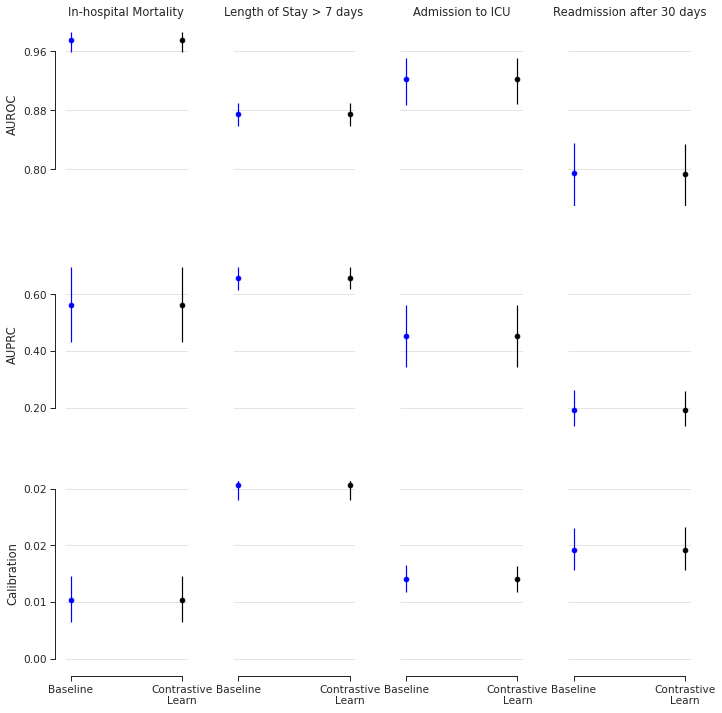

In [116]:
# For each task plot baseline vs CL
fig, axes = plt.subplots(nrows=len(metrics), ncols=len(tasks), figsize=(10,12))
plt.tight_layout(w_pad=1,h_pad=2,rect=[0.05,0.15,1,0.95])

for r, metric in enumerate(metrics):
    for c, task in enumerate(tasks):
        bl_evals = bl_df.query('task==@task and metric==@metric')
        cl_evals = cl_df.query('task==@task and metric==@metric')
        
        bl_evals['CI_upper'] = (bl_evals['CI_upper'] - bl_evals['CI_med']).abs()
        bl_evals['CI_lower'] = (bl_evals['CI_med'] - bl_evals['CI_lower']).abs()
        
        cl_evals['CI_upper'] = (cl_evals['CI_upper'] - cl_evals['CI_med']).abs()
        cl_evals['CI_lower'] = (cl_evals['CI_med'] - cl_evals['CI_lower']).abs()
        
        axes[r][c].scatter(
            bl_evals['model'],
            bl_evals['CI_med'],
            color = 'blue'
        )
        
        axes[r][c].errorbar(
            bl_evals['model'],
            bl_evals['CI_med'],
            bl_evals[['CI_lower', 'CI_upper']].values.T,
            color='blue'
        )
        
        axes[r][c].scatter(
            cl_evals['model'],
            cl_evals['CI_med'],
            color = 'black'
        )
        
        axes[r][c].errorbar(
            cl_evals['model'],
            cl_evals['CI_med'],
            cl_evals[['CI_lower', 'CI_upper']].values.T,
            color = 'black'
        )
        
        
        axes[r][c].set_ylim(y_axis[metric]['lim'])
        axes[r][c].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
        axes[r][c].grid(which='major', linewidth=0.5, axis='y')
        if r == 0:
            axes[r][c].set_title(titles[task])
        if r == len(metrics) - 1:
            axes[r][c].set_xlabel('')
            axes[r][c].set_xticklabels(labels=['Baseline', 'Contrastive\nLearn'])
        else:
            axes[r][c].set_xticklabels('')
            axes[r][c].set_xlabel('')
            axes[r][c].spines['bottom'].set_color('white')
            axes[r][c].tick_params(axis='x', length=0)  
        if c == 0:
            axes[r][c].set_ylabel(y_axis[metric]['label'])
            axes[r][c].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            axes[r][c].set_yticklabels('')
            axes[r][c].set_ylabel('')
            axes[r][c].spines['left'].set_color('white')
            axes[r][c].tick_params(axis='y', length=0)
sns.despine(offset=10, trim=True,)

plt.show()
        